In [ ]:
# For data manipulation and analysis
import pandas as pd
import numpy as np

# For text preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# For machine learning models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# For evaluation metrics
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os


train_zip_path = '/content/drive/My Drive/gener_train_data.zip'
test_zip_path = '/content/drive/My Drive/gener_test_data.zip'
test_solution_zip_path = '/content/drive/My Drive/gener_test_data_solution.zip'


with zipfile.ZipFile(train_zip_path, 'r') as train_zip:
    train_zip.extractall('/content/train_data')


with zipfile.ZipFile(test_zip_path, 'r') as test_zip:
    test_zip.extractall('/content/test_data')

with zipfile.ZipFile(test_solution_zip_path, 'r') as test_solution_zip:
    test_solution_zip.extractall('/content/test_solution_data')


In [ ]:
# Load the datasets into pandas DataFrames
train_df = pd.read_csv('/content/train_data/gener_train_data.txt', delimiter=' ::: ', engine='python', names=['Index', 'Title', 'Genre', 'Description'])
test_df = pd.read_csv('/content/test_data/gener_test_data.txt', delimiter=' ::: ', engine='python', names=['Index', 'Title', 'Description'])
test_solution_df = pd.read_csv('/content/test_solution_data/gener_test_data_solution.txt', delimiter=' ::: ', engine='python', names=['Index', 'Title', 'Genre', 'Description'])


In [ ]:
train_df.columns

Index(['Index', 'Title', 'Genre', 'Description'], dtype='object')

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stop words and lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]

    return ' '.join(tokens)

# Apply preprocessing to the Description column
train_df['Description'] = train_df['Description'].apply(preprocess_text)
test_df['Description'] = test_df['Description'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


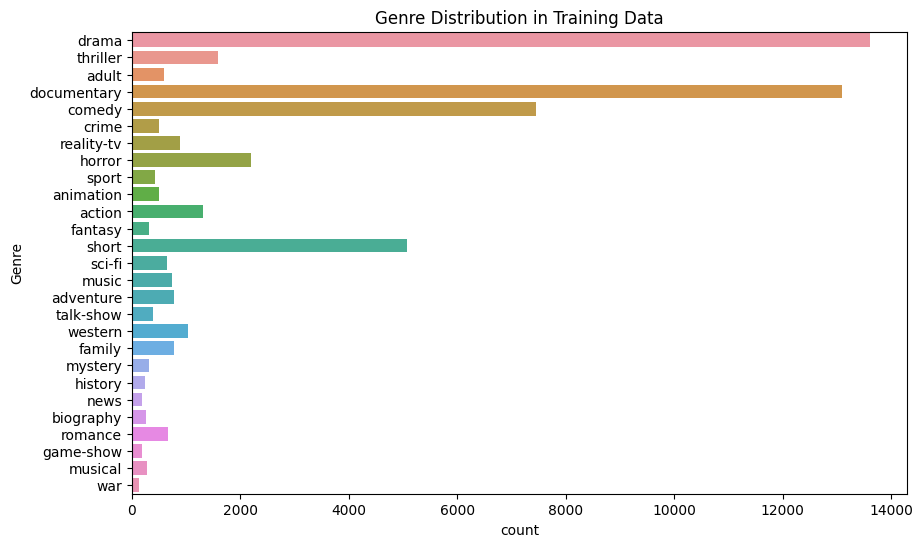

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Genre distribution
plt.figure(figsize=(10,6))
sns.countplot(data=train_df, y='Genre')
plt.title('Genre Distribution in Training Data')
plt.show()

In [ ]:
# Word Frequency Analysis
all_words = ' '.join([text for text in train_df['Description']]).split()
freq_dist = nltk.FreqDist(all_words)
print(freq_dist.most_common(20))

[('life', 23904), ('one', 17439), ('film', 14637), ('story', 12672), ('world', 11629), ('year', 11625), ('new', 11524), ('find', 11311), ('family', 10805), ('get', 10121), ('young', 10099), ('love', 10041), ('time', 9831), ('take', 9530), ('two', 9488), ('woman', 9388), ('friend', 9171), ('man', 9087), ('people', 8184), ('day', 8065)]


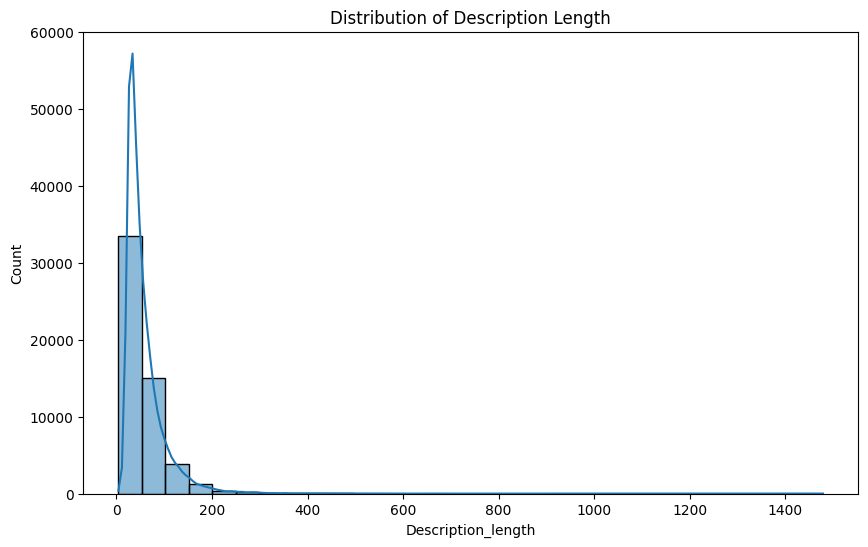

In [ ]:
# Text Length Analysis
train_df['Description_length'] = train_df['Description'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(train_df['Description_length'], bins=30, kde=True)
plt.title('Distribution of Description Length')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the vectorizer on the training data 'Description' column
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['Description'])

# Only transform the test data 'Description' column
X_test_tfidf = tfidf_vectorizer.transform(test_df['Description'])



In [ ]:
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE()

# Fit SMOTE on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, train_df['Genre'])

# Check the new class distribution
print(sorted(Counter(y_train_resampled).items()))


[('action', 13613), ('adult', 13613), ('adventure', 13613), ('animation', 13613), ('biography', 13613), ('comedy', 13613), ('crime', 13613), ('documentary', 13613), ('drama', 13613), ('family', 13613), ('fantasy', 13613), ('game-show', 13613), ('history', 13613), ('horror', 13613), ('music', 13613), ('musical', 13613), ('mystery', 13613), ('news', 13613), ('reality-tv', 13613), ('romance', 13613), ('sci-fi', 13613), ('short', 13613), ('sport', 13613), ('talk-show', 13613), ('thriller', 13613), ('war', 13613), ('western', 13613)]


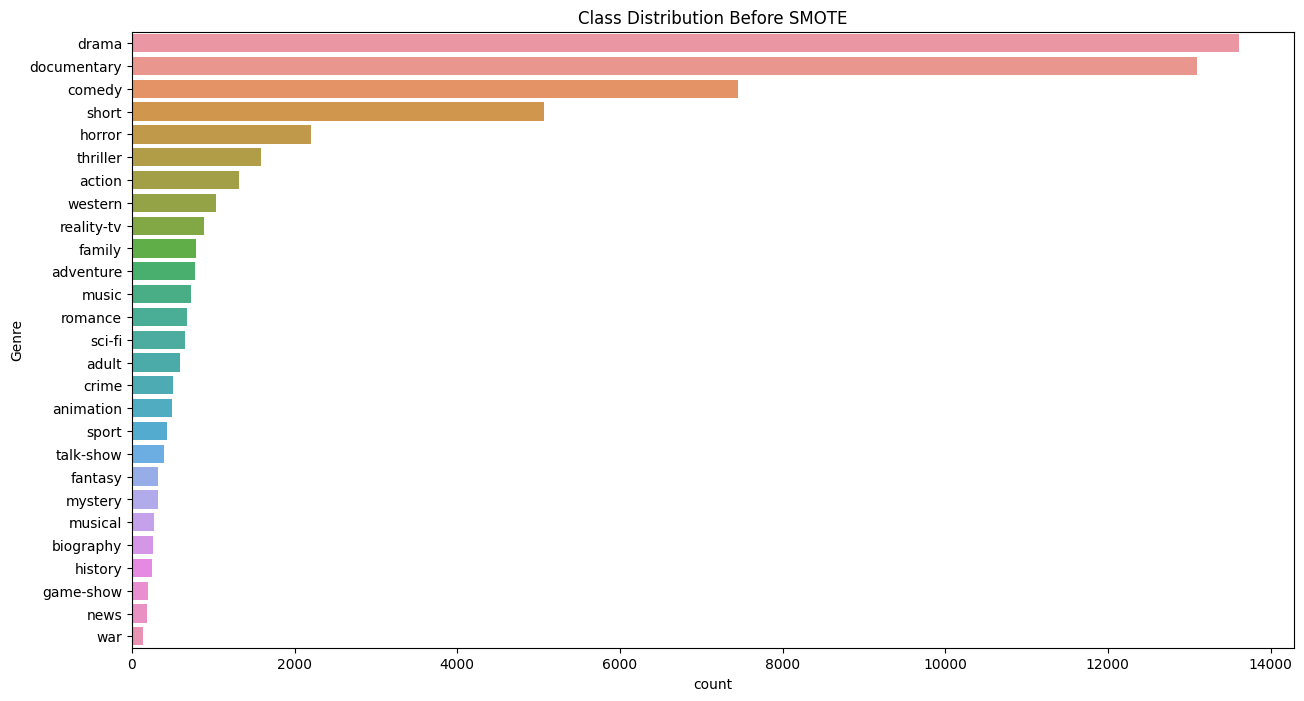

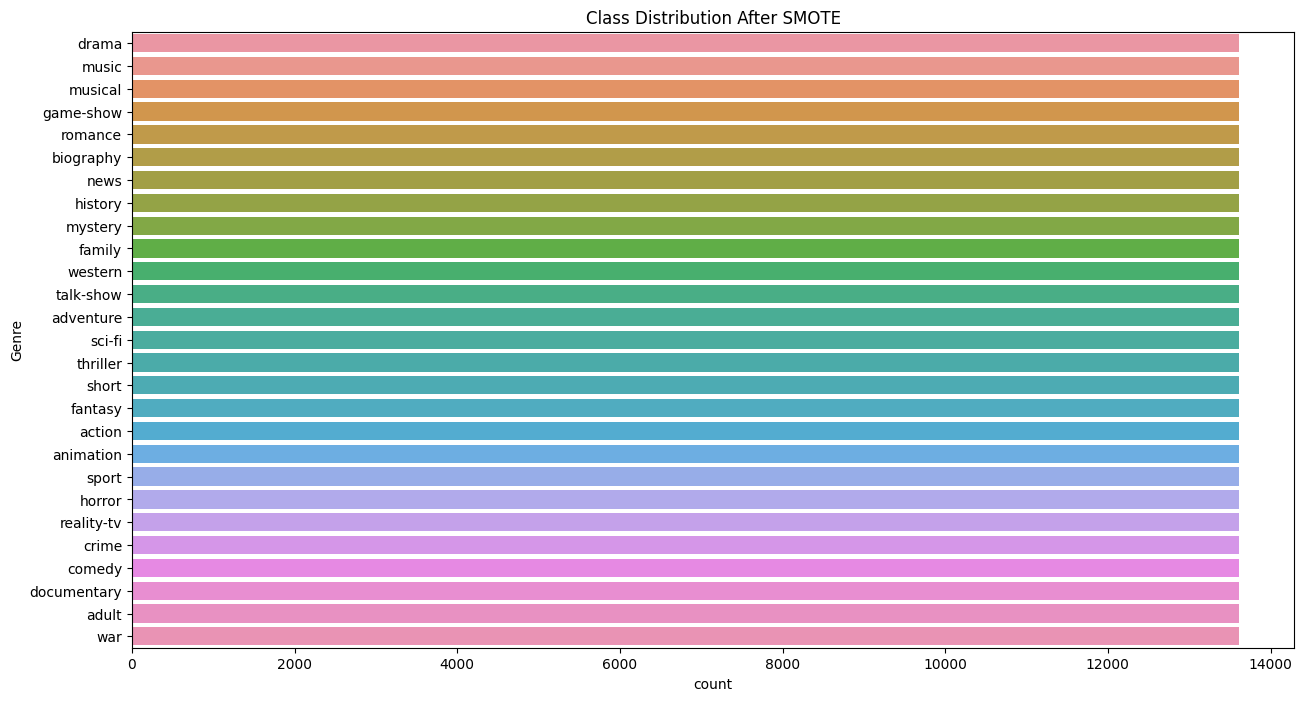

In [ ]:
# Before SMOTE
plt.figure(figsize=(15, 8))
sns.countplot(y=train_df['Genre'], order = train_df['Genre'].value_counts().index)
plt.title('Class Distribution Before SMOTE')
plt.show()

# After SMOTE
plt.figure(figsize=(15, 8))
sns.countplot(y=y_train_resampled, order = y_train_resampled.value_counts().index)
plt.title('Class Distribution After SMOTE')
plt.show()


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score

# Preparing a dictionary to hold our results
results = {}

# Models to train
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'LinearSVC': LinearSVC(max_iter=10000)
}

trained_models = {}
# Train each model and store the results in the dictionary
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    trained_models[model_name] = model
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)

    # Store the scores in the dictionary
    results[model_name] = {
        'Accuracy': accuracy_score(y_val, y_val_pred),
        'F1 Score': f1_score(y_val, y_val_pred, average='weighted'),
        'Precision': precision_score(y_val, y_val_pred, average='weighted')
    }

# Convert the results dictionary to a DataFrame for display
results_df = pd.DataFrame(results).T


In [ ]:
# Convert the results dictionary to a DataFrame for display
results_df = pd.DataFrame(results).T

# Display the results DataFrame
print(results_df)


                    Accuracy  F1 Score  Precision
MultinomialNB       0.577792  0.586820   0.647913
LogisticRegression  0.695841  0.697818   0.740911
LinearSVC           0.730702  0.726117   0.759915


In [ ]:
# Now we can use the trained LinearSVC model to make predictions
linear_svc_model = trained_models['LinearSVC']
# Predict genres on the vectorized test data
y_test_pred = linear_svc_model.predict(X_test_tfidf)

# The actual genres are in the 'Genre' column of test_solution_df
y_test_actual = test_solution_df['Genre']

# Generate a classification report
report = classification_report(y_test_actual, y_test_pred, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the classification report DataFrame
print(report_df)


comparison_df = pd.DataFrame({
    'Actual': y_test_actual,
    'Predicted': y_test_pred
})

print(comparison_df.head())


              precision    recall  f1-score       support
action         0.229245  0.369863  0.283052   1314.000000
adult          0.327189  0.481356  0.389575    590.000000
adventure      0.149815  0.261935  0.190610    775.000000
animation      0.128272  0.196787  0.155309    498.000000
biography      0.035581  0.071970  0.047619    264.000000
comedy         0.518039  0.457024  0.485623   7446.000000
crime          0.106952  0.198020  0.138889    505.000000
documentary    0.750047  0.614539  0.675565  13096.000000
drama          0.646695  0.384587  0.482333  13612.000000
family         0.123077  0.245211  0.163892    783.000000
fantasy        0.108209  0.180124  0.135198    322.000000
game-show      0.616580  0.616580  0.616580    193.000000
history        0.060759  0.098765  0.075235    243.000000
horror         0.456538  0.557623  0.502042   2204.000000
music          0.406796  0.573187  0.475866    731.000000
musical        0.095122  0.141304  0.113703    276.000000
mystery       